Given a results folder, plot the rewards across context values

In [1]:

# dataframe with columns: context_mode, seed, context_value, reward
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

def wilcoxon_test(df: pd.DataFrame, context_mode_1: str, context_mode_2: str):
    """
    Given a dataframe with columns: context_mode, seed, context_value, reward
    performs a wilcoxon test for each context_value for the given pair of context_mode
    returns a dataframe with columns: context_value, statistic, p_value
    """
    wilcoxon_df = pd.DataFrame(columns=["context_value", "statistic", "p_value", "higher_mean", context_mode_1, context_mode_2])
    for context_value in df["context_value"].unique():
        rewards_1 = df[(df["context_mode"] == context_mode_1) & (df["context_value"] == context_value)]["reward"]
        rewards_2 = df[(df["context_mode"] == context_mode_2) & (df["context_value"] == context_value)]["reward"]
        try:
            statistic, p_value = wilcoxon(rewards_1, rewards_2)
        except ValueError:
            statistic, p_value = 0, 1
        higher_mean = context_mode_1 if rewards_1.mean() > rewards_2.mean() else context_mode_2
        wilcoxon_df = wilcoxon_df._append({"context_value": context_value, "statistic": statistic, "p_value": p_value, "higher_mean": higher_mean, context_mode_1: rewards_1.mean(), context_mode_2: rewards_2.mean()}, ignore_index=True)
    return wilcoxon_df



def plot_rewards(run_dir: str, 
                 context_modes = "all", 
                 context_colors = None,
                 environment_name = "",
                 train_values = [], 
                 eval_values = []):
    """
    given a run directory, plots the rewards for each context value for each context mode
    """
    # run_dir = parent of current dir + run_dir
    run_dir = os.path.join(os.path.dirname(os.getcwd()), run_dir)
    reward_df = pd.DataFrame(columns=["context_mode", "seed", "context_value", "reward"])

    for root, dirs, files in os.walk(run_dir):
        for file in files:
            if file.startswith("sac_rewards_") and file.endswith(".json"):
                # files are named "sac_rewards_{env_id}_{context_mode}_{seed}.json"
                with open(os.path.join(root, file), "r") as f:
                    data = json.load(f)
                    # data is a dict with {"context_value":rewards}
                    context_mode = file.split("_")[3] + ('_' + file.split("_")[4] if file.split("_")[3] == 'learned' else '') # 'contextual' or 'noncontextual
                    seed = int(file.split("_")[-1].split(".")[0])
                    if context_modes == "all" or context_mode in context_modes:
                        for context_value, rewards in data.items():
                            for reward in rewards:
                                reward_df = reward_df._append({"context_mode": context_mode, "seed": seed, "context_value": context_value, "reward": reward}, ignore_index=True)

    
    plt.figure(figsize=(20, 6))
    # print statistics for each column

    

    sns.violinplot(data=reward_df, x="context_value", y="reward", hue="context_mode", palette=context_colors, scale="width", )#inner="quartile")



    
    # Draw vertical bands at the specific points
    for point in train_values:
        plt.axvline(x=point/10, color='k', linestyle=(0, (1, 10)))

    for point in eval_values:
        plt.axvline(x=point/10, color='k', linestyle=':')
    
    if environment_name != "":
        plt.title(f"Rewards for each context value in {environment_name}")
    plt.show()
    
    display(wilcoxon_test(reward_df, "learned_jcpl", "learned_iida").T)
    
    """
    plot_p_values(wilcoxon_df)
    """
    

/tmp/ipykernel_598158/2381075848.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Plots for the presentation

/tmp/ipykernel_380987/2381075848.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reward_df = reward_df._append({"context_mode": context_mode, "seed": seed, "context_value": context_value, "reward": reward}, ignore_index=True)
/tmp/ipykernel_380987/2381075848.py:63: UserWarning: The palette list has more values (2) than needed (1), which may not be intended.
  sns.violinplot(data=reward_df, x="context_value", y="reward", hue="context_mode", palette=context_colors, scale="width", )#inner="quartile")
/tmp/ipykernel_380987/2381075848.py:63: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=reward_df, x="context_value", y="reward", h

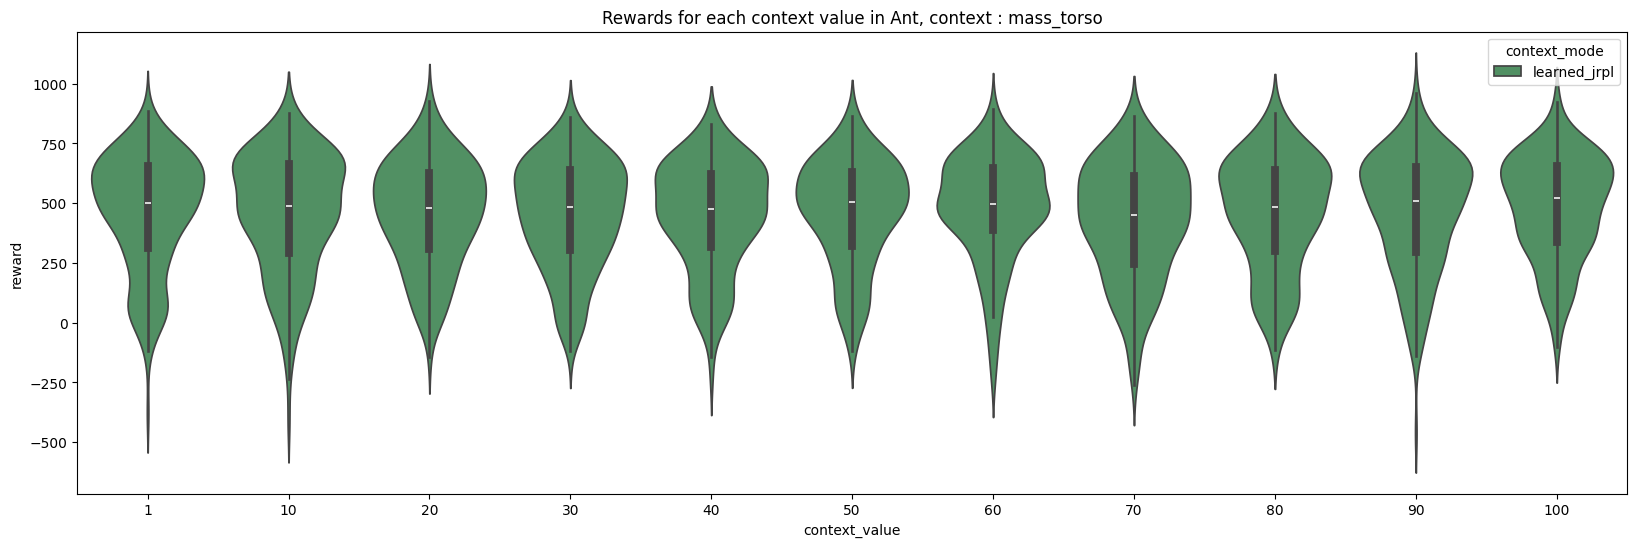

/tmp/ipykernel_380987/2381075848.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  wilcoxon_df = wilcoxon_df._append({"context_value": context_value, "statistic": statistic, "p_value": p_value, "higher_mean": higher_mean, context_mode_1: rewards_1.mean(), context_mode_2: rewards_2.mean()}, ignore_index=True)


,0,1,2,3,4,5,6,7,8,9,10
context_value,1,10,20,30,40,50,60,70,80,90,100
statistic,0,0,0,0,0,0,0,0,0,0,0
p_value,1,1,1,1,1,1,1,1,1,1,1
higher_mean,learned_iida,learned_iida,learned_iida,learned_iida,learned_iida,learned_iida,learned_iida,learned_iida,learned_iida,learned_iida,learned_iida
learned_jcpl,461.756659,456.453305,455.008029,448.850097,444.141896,460.292029,476.800454,424.863562,456.35765,464.405499,484.112523
learned_iida,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
colors = (71,154,95,1), (218, 76, 76, 1)
# need to divide by 255 to get the right colors
colors = [(r/255, g/255, b/255, a) for r, g, b, a in colors]

plot_rewards("results/hydra/multirun/2024-02-07/20-31-42", 
             context_modes = ["learned_jcpl"],
                context_colors = colors,
             #train_values=[25, 35, 45, 55, 65, 75],
            #eval_values=[1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            environment_name="Ant, context : mass_torso")

# train_env : [25, 35, 45, 55, 65, 75]
# test_env : [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100] 

In [6]:
# Env: CARLMountainCarContinuous, context: power, total_timesteps: 30000
# train_env : [-5, -3, -1, 1, 3, 5]
# test_env :  [-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10]
plot_rewards("results/hydra/multirun/2024-02-09/18-52-53", 
             context_modes = ["learned_iida", "learned_jcpl", "default", "explicit", "hidden"],
              #  context_colors = colors,
             #train_values=[0.00742415, 0.01238423, 0.02065813, 0.03445984, 0.05748248],
            #eval_values=[0.002     , 0.0033362 , 0.00556512, 0.00928318, 0.01548527, 0.02583099, 0.04308869, 0.07187627, 0.11989685, 0.2       ],
            environment_name="MountainCarContinuous, context : power")

/tmp/ipykernel_380987/2381075848.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reward_df = reward_df._append({"context_mode": context_mode, "seed": seed, "context_value": context_value, "reward": reward}, ignore_index=True)
/tmp/ipykernel_380987/2381075848.py:63: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=reward_df, x="context_value", y="reward", hue="context_mode", palette=context_colors, scale="width", )#inner="quartile")


/tmp/ipykernel_380987/2381075848.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  wilcoxon_df = wilcoxon_df._append({"context_value": context_value, "statistic": statistic, "p_value": p_value, "higher_mean": higher_mean, context_mode_1: rewards_1.mean(), context_mode_2: rewards_2.mean()}, ignore_index=True)


,0,1,2,3,4,5,6,7,8,9,10
context_value,-10,-8,-6,-4,-2,0,2,4,6,8,10
statistic,7427.0,6917.0,7090.0,6668.0,6782.0,3810.0,2532.0,1623.0,1526.0,1514.0,1507.0
p_value,0.001372,0.000132,0.000304,0.000037,0.000067,0.0,0.0,0.0,0.0,0.0,0.0
higher_mean,learned_jcpl,learned_jcpl,learned_jcpl,learned_jcpl,learned_jcpl,learned_jcpl,learned_jcpl,learned_jcpl,learned_jcpl,learned_jcpl,learned_jcpl
learned_jcpl,62.140809,66.585016,65.542153,64.063097,64.870318,-10.157931,76.669988,76.707859,76.817229,76.745858,76.780243
learned_iida,41.677323,42.865118,41.252703,40.717111,42.809788,-10.855284,39.457508,33.365379,32.109724,30.738708,31.215485


In [7]:
plot_rewards("results/hydra/multirun/2024-02-09/13-33-44", 
             context_modes = ["learned_iida", "learned_jcpl"],
             context_colors = colors,
             #train_values=[0.00742415, 0.01238423, 0.02065813, 0.03445984, 0.05748248],
            #eval_values=[0.002     , 0.0033362 , 0.00556512, 0.00928318, 0.01548527, 0.02583099, 0.04308869, 0.07187627, 0.11989685, 0.2       ],
            environment_name="CARLPendulum, context : length")

/tmp/ipykernel_2410964/4195471241.py:90: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reward_df = reward_df._append({"context_mode": context_mode, "seed": seed, "context_value": context_value, "reward": reward}, ignore_index=True)
/tmp/ipykernel_2410964/4195471241.py:95: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=reward_df, x="context_value", y="reward", hue="context_mode", palette=context_colors, scale="width", )#inner="quartile")


/tmp/ipykernel_2410964/4195471241.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  wilcoxon_df = wilcoxon_df._append({"context_value": context_value, "statistic": statistic, "p_value": p_value, "higher_mean": higher_mean, context_mode_1: rewards_1.mean(), context_mode_2: rewards_2.mean()}, ignore_index=True)


,0,1,2,3,4,5,6,7,8,9
context_value,0.01,0.02154435,0.04641589,0.1,0.21544347,0.46415888,1.0,2.15443469,4.64158883,10.0
statistic,8942.0,7809.0,8540.0,4256.0,5179.0,114.0,9.0,3586.0,9399.0,9868.0
p_value,0.176392,0.006249,0.065408,0.0,0.0,0.0,0.0,0.0,0.427003,0.824259
higher_mean,learned_iida,learned_iida,learned_jcpl,learned_iida,learned_iida,learned_jcpl,learned_jcpl,learned_jcpl,learned_jcpl,learned_jcpl
learned_jcpl,-1325.498718,-1323.243874,-1231.096948,-107.576718,-68.270311,-98.574565,-180.164045,-761.853452,-913.739079,-904.836874
learned_iida,-1320.142253,-1313.341358,-1273.821183,-106.914943,-51.011197,-646.08119,-981.950797,-984.139031,-954.298292,-908.715053


/tmp/ipykernel_2410964/4195471241.py:90: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reward_df = reward_df._append({"context_mode": context_mode, "seed": seed, "context_value": context_value, "reward": reward}, ignore_index=True)
/tmp/ipykernel_2410964/4195471241.py:95: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=reward_df, x="context_value", y="reward", hue="context_mode", palette=context_colors, scale="width", )#inner="quartile")


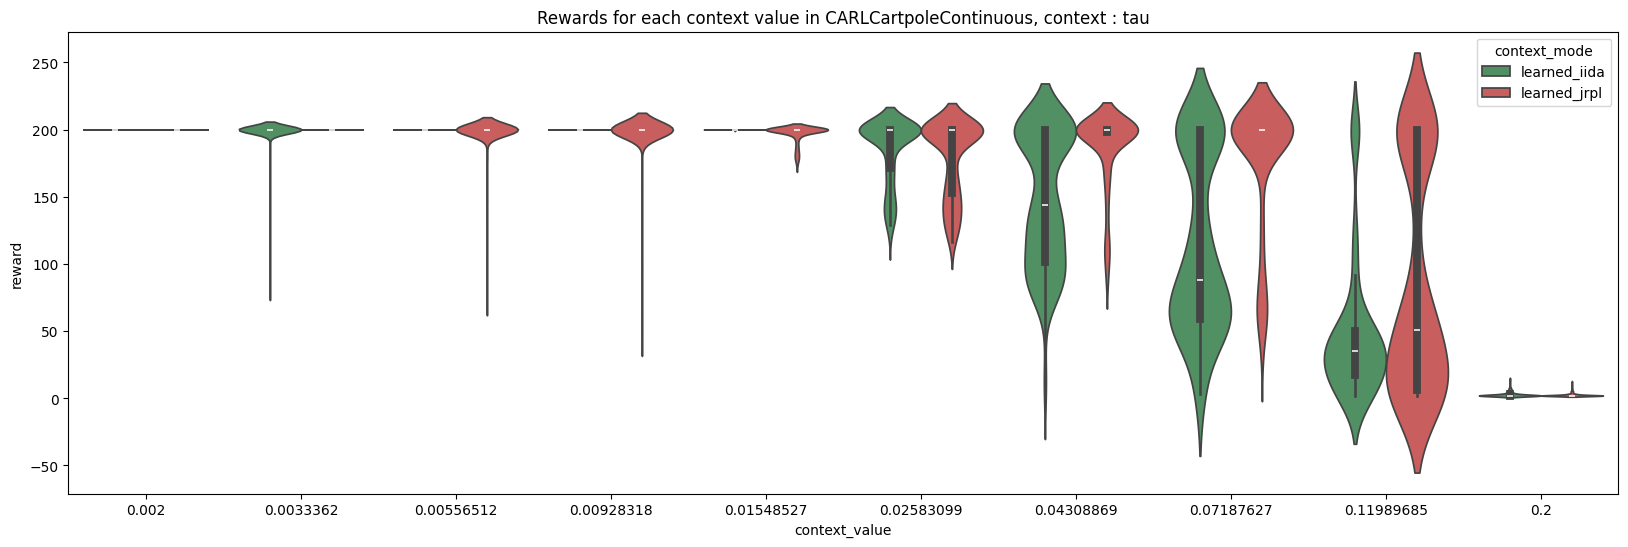

/tmp/ipykernel_2410964/4195471241.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  wilcoxon_df = wilcoxon_df._append({"context_value": context_value, "statistic": statistic, "p_value": p_value, "higher_mean": higher_mean, context_mode_1: rewards_1.mean(), context_mode_2: rewards_2.mean()}, ignore_index=True)
/home/ndirt/miniconda3/envs/meta_rl_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/home/ndirt/miniconda3/envs/meta_rl_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for no

,0,1,2,3,4,5,6,7,8,9
context_value,0.002,0.0033362,0.00556512,0.00928318,0.01548527,0.02583099,0.04308869,0.07187627,0.11989685,0.2
statistic,0,0.0,0.0,0.0,1.0,3263.5,1296.0,1908.0,5465.5,1307.0
p_value,1,0.317311,0.011719,0.027708,0.0,0.054069,0.0,0.0,0.000003,0.031133
higher_mean,learned_iida,learned_jcpl,learned_iida,learned_iida,learned_iida,learned_iida,learned_jcpl,learned_jcpl,learned_jcpl,learned_iida
learned_jcpl,200.0,200.0,197.8,197.09,197.12,178.495,186.035,173.835,84.71,2.455
learned_iida,200.0,199.395,200.0,200.0,199.995,184.72,147.985,113.765,47.655,2.795


In [8]:
plot_rewards("results/hydra/multirun/2024-02-08/13-15-57", 
             context_modes = ["learned_iida", "learned_jcpl"],
             context_colors = colors,
             #train_values=[0.00742415, 0.01238423, 0.02065813, 0.03445984, 0.05748248],
            #eval_values=[0.002     , 0.0033362 , 0.00556512, 0.00928318, 0.01548527, 0.02583099, 0.04308869, 0.07187627, 0.11989685, 0.2       ],
            environment_name="CARLCartpoleContinuous, context : tau")

In [6]:
# Env: CARLBraxAnt, context: mass_torso, total_timesteps: 30000
# train_env : lower_bound_coeff: 0.2, upper_bound_coeff: 2.0, distribution: uniform (100 samples)
# test_env : lower_bound_coeff: 0.1, upper_bound_coeff: 4.0, distribution: discrete (10 samples) 
plot_rewards("results/hydra/multirun/2024-02-03/12-49-45")

TypeError: 'float' object is not iterable

/tmp/ipykernel_1432602/884721006.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reward_df = reward_df._append({"context_mode": context_mode, "seed": seed, "context_value": context_value, "reward": reward}, ignore_index=True)


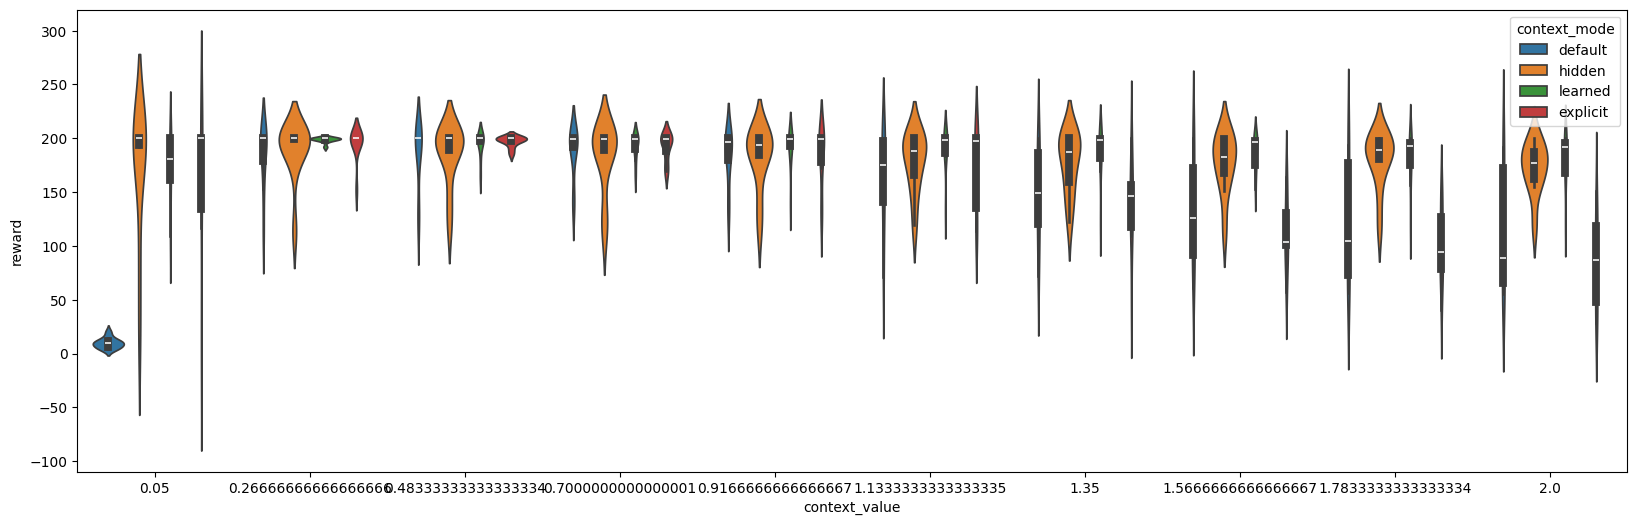

In [3]:
# Env: CARLCartpoleContinuous, context: length, total_timesteps: 30000
# train_env : lower_bound_coeff: 0.2, upper_bound_coeff: 2.0, distribution: uniform (100 samples)
# test_env : lower_bound_coeff: 0.1, upper_bound_coeff: 4.0, distribution: discrete (10 samples) 
plot_rewards("results/hydra/multirun/2024-02-03/21-16-29")


/tmp/ipykernel_2984725/2122905763.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reward_df = reward_df._append({"context_mode": context_mode, "seed": seed, "context_value": context_value, "reward": reward}, ignore_index=True)


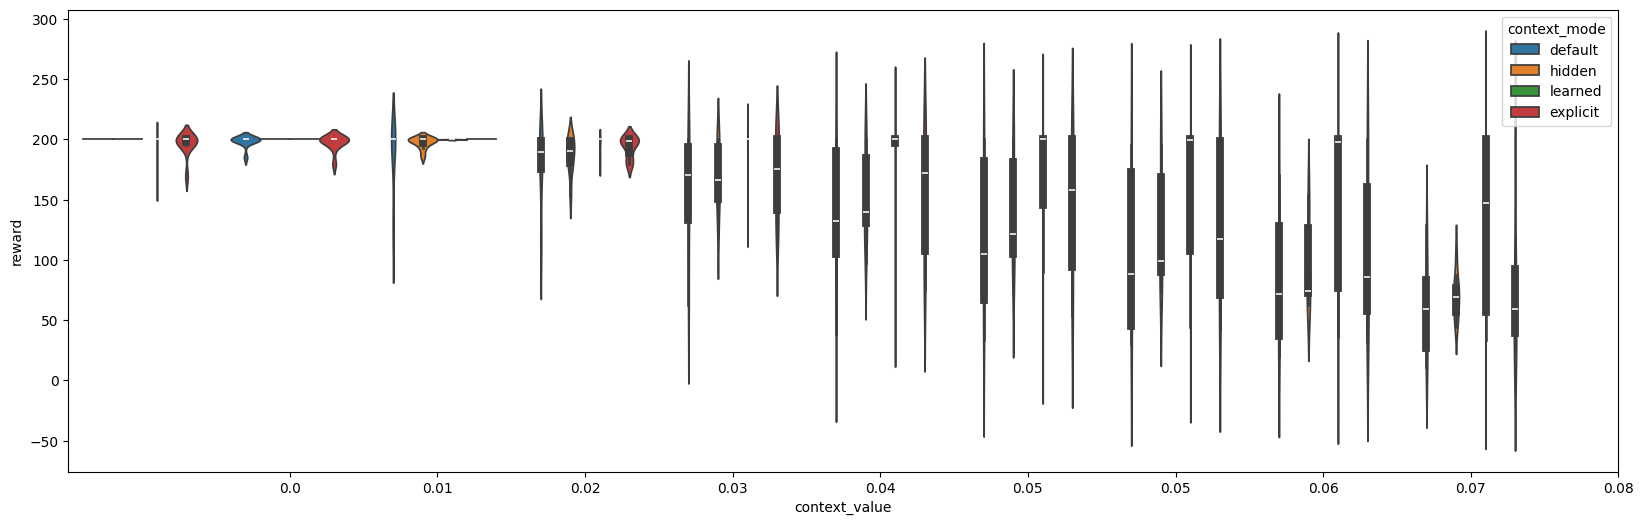

In [10]:
# Env: CARLCartpoleContinuous, context: tau, total_timesteps: 30000
# train_env : lower_bound_coeff: 0.2, upper_bound_coeff: 2.0, distribution: uniform (100 samples)
# test_env : lower_bound_coeff: 0.1, upper_bound_coeff: 4.0, distribution: discrete (10 samples) 
plot_rewards("results/hydra/multirun/2024-02-04/12-24-04")


/tmp/ipykernel_2944974/884721006.py:27: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reward_df = reward_df._append({"context_mode": context_mode, "seed": seed, "context_value": context_value, "reward": reward}, ignore_index=True)


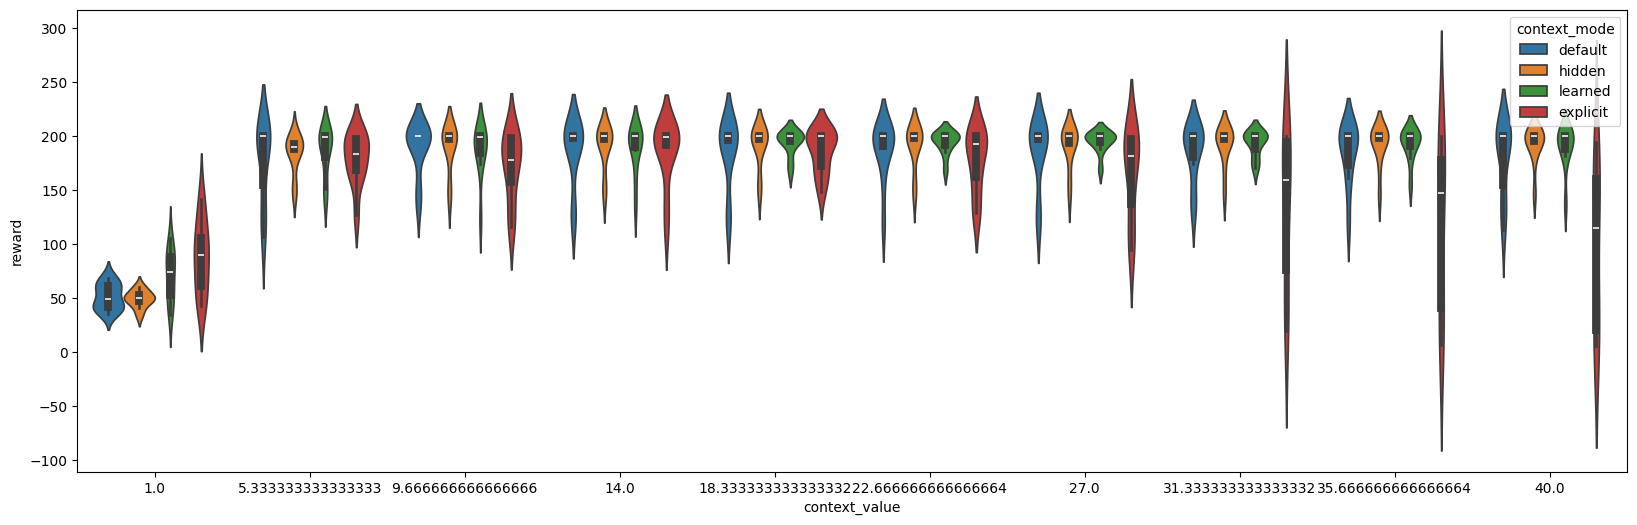

In [3]:
# Env: CARLCartpoleContinuous, context: force_mag, total_timesteps: 30000
# train_env : lower_bound_coeff: 0.2, upper_bound_coeff: 2.0, distribution: uniform (100 samples)
# test_env : lower_bound_coeff: 0.1, upper_bound_coeff: 4.0, distribution: discrete (10 samples) 
plot_rewards("results/hydra/multirun/2024-02-05/00-24-42")



## Discrete train and eval sets

In [2]:
# Env: CARLBraxAnt, context: mass_torso, total_timesteps: 30000
# train_env : [25, 35, 45, 55, 65, 75]
# test_env : [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100] 
plot_rewards("results/hydra/multirun/2024-02-07/20-31-42", 
             context_modes = ["hidden", "learned_iida", "learned_jcpl"],
             train_values=[25, 35, 45, 55, 65, 75],
            eval_values=[1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            environment_name="Ant, context : mass_torso")

/tmp/ipykernel_3795575/272990189.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reward_df = reward_df._append({"context_mode": context_mode, "seed": seed, "context_value": context_value, "reward": reward}, ignore_index=True)


/tmp/ipykernel_526288/2381075848.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reward_df = reward_df._append({"context_mode": context_mode, "seed": seed, "context_value": context_value, "reward": reward}, ignore_index=True)
/tmp/ipykernel_526288/2381075848.py:63: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=reward_df, x="context_value", y="reward", hue="context_mode", palette=context_colors, scale="width", )#inner="quartile")


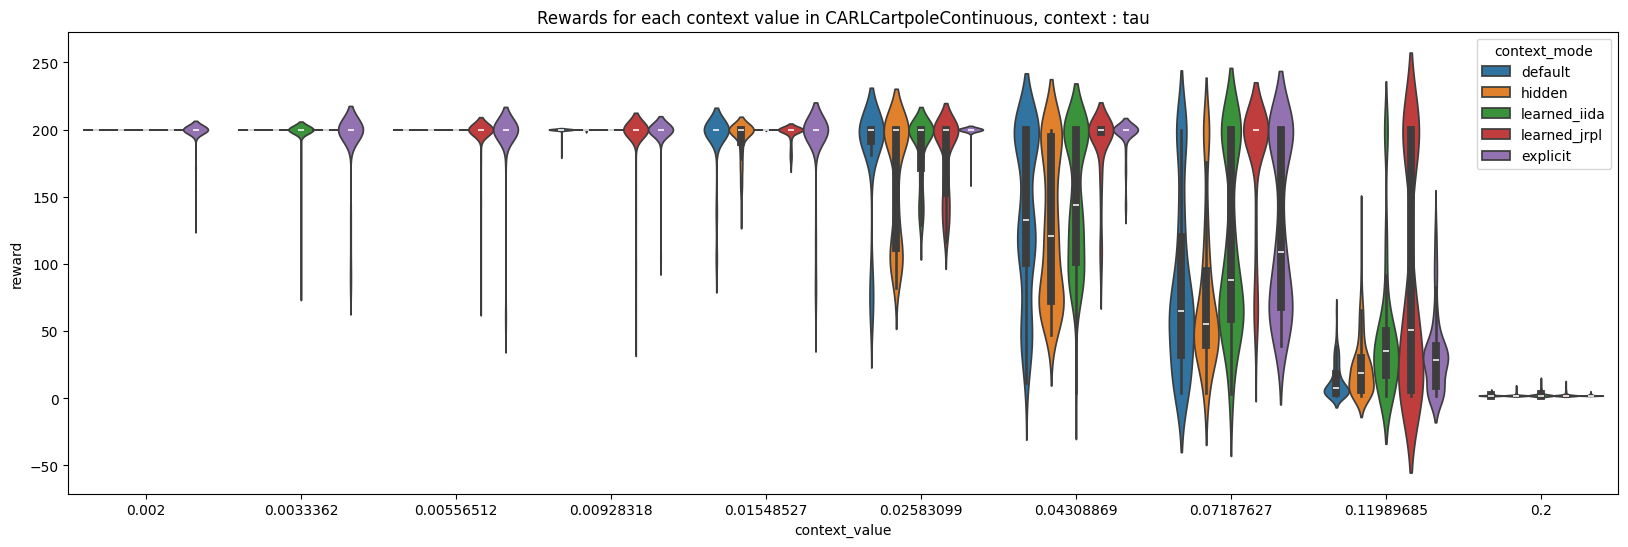

/tmp/ipykernel_526288/2381075848.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  wilcoxon_df = wilcoxon_df._append({"context_value": context_value, "statistic": statistic, "p_value": p_value, "higher_mean": higher_mean, context_mode_1: rewards_1.mean(), context_mode_2: rewards_2.mean()}, ignore_index=True)
/home/ndirt/miniconda3/envs/meta_rl_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")
/home/ndirt/miniconda3/envs/meta_rl_env/lib/python3.10/site-packages/scipy/stats/_morestats.py:4102: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for nor

,0,1,2,3,4,5,6,7,8,9
context_value,0.002,0.0033362,0.00556512,0.00928318,0.01548527,0.02583099,0.04308869,0.07187627,0.11989685,0.2
statistic,0,0.0,0.0,0.0,1.0,3263.5,1296.0,1908.0,5465.5,1307.0
p_value,1,0.317311,0.011719,0.027708,0.0,0.054069,0.0,0.0,0.000003,0.031133
higher_mean,learned_iida,learned_jcpl,learned_iida,learned_iida,learned_iida,learned_iida,learned_jcpl,learned_jcpl,learned_jcpl,learned_iida
learned_jcpl,200.0,200.0,197.8,197.09,197.12,178.495,186.035,173.835,84.71,2.455
learned_iida,200.0,199.395,200.0,200.0,199.995,184.72,147.985,113.765,47.655,2.795


In [4]:
# Env: CARLCartpoleContinuous, context: tau, total_timesteps: 30000
# train_env : 5 mean points between the 6 middle test values [0.00742415, 0.01238423, 0.02065813, 0.03445984, 0.05748248]
# test_env : 10 values between 0.002 and 0.2 (logscale) [0.002     , 0.0033362 , 0.00556512, 0.00928318, 0.01548527, 0.02583099, 0.04308869, 0.07187627, 0.11989685, 0.2       ]
plot_rewards("results/hydra/multirun/2024-02-08/13-15-57", 
             context_modes = ["hidden", "learned_iida", "learned_jcpl", "default", "explicit"],
             #train_values=[0.00742415, 0.01238423, 0.02065813, 0.03445984, 0.05748248],
            #eval_values=[0.002     , 0.0033362 , 0.00556512, 0.00928318, 0.01548527, 0.02583099, 0.04308869, 0.07187627, 0.11989685, 0.2       ],
            environment_name="CARLCartpoleContinuous, context : tau")

/tmp/ipykernel_598158/2381075848.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reward_df = reward_df._append({"context_mode": context_mode, "seed": seed, "context_value": context_value, "reward": reward}, ignore_index=True)


/tmp/ipykernel_598158/2381075848.py:63: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=reward_df, x="context_value", y="reward", hue="context_mode", palette=context_colors, scale="width", )#inner="quartile")


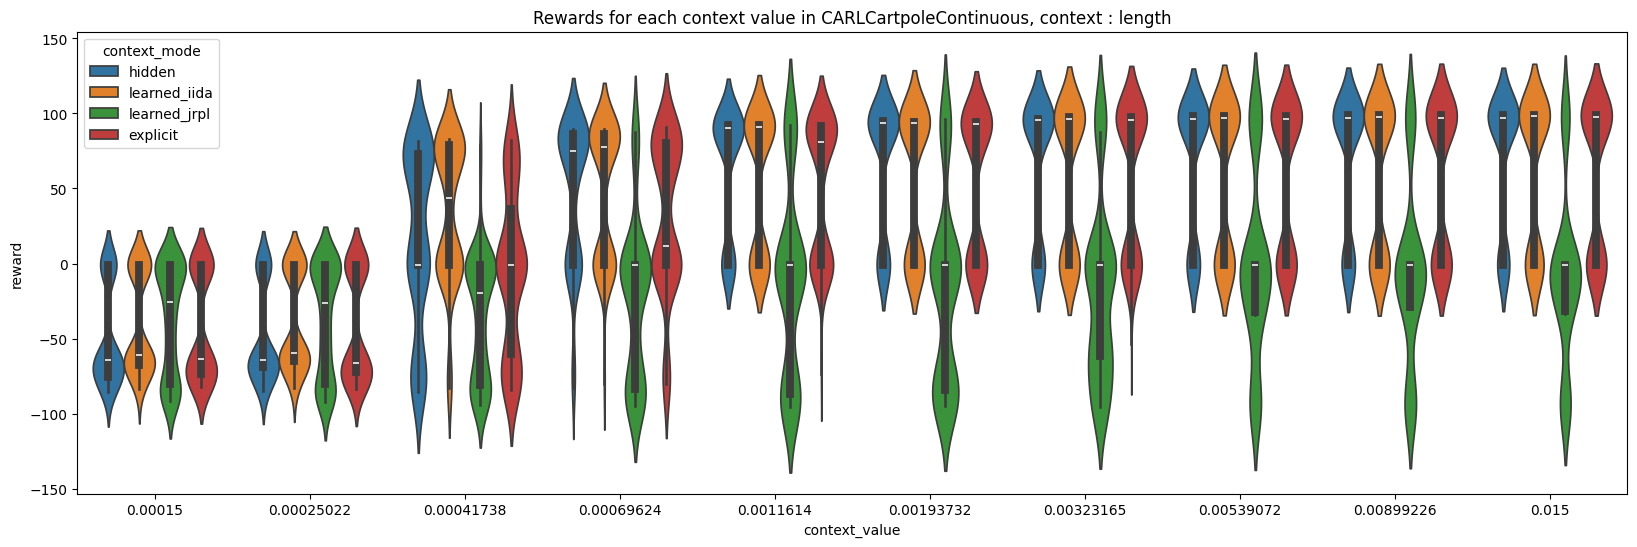

/tmp/ipykernel_598158/2381075848.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  wilcoxon_df = wilcoxon_df._append({"context_value": context_value, "statistic": statistic, "p_value": p_value, "higher_mean": higher_mean, context_mode_1: rewards_1.mean(), context_mode_2: rewards_2.mean()}, ignore_index=True)


,0,1,2,3,4,5,6,7,8,9
context_value,0.00015,0.00025022,0.00041738,0.00069624,0.0011614,0.00193732,0.00323165,0.00539072,0.00899226,0.015
statistic,9609.0,9050.0,1207.0,1664.0,898.0,364.0,434.0,376.0,1150.0,1203.0
p_value,0.590511,0.2224,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
higher_mean,learned_jcpl,learned_jcpl,learned_iida,learned_iida,learned_iida,learned_iida,learned_iida,learned_iida,learned_iida,learned_iida
learned_jcpl,-36.878557,-37.450713,-34.653249,-22.69746,-11.465542,-19.784025,-17.802791,-3.273256,-7.436203,-10.126132
learned_iida,-40.529786,-39.42362,32.952572,47.014981,54.764665,56.265091,57.806544,58.447492,58.748429,61.372382


In [3]:
# Env: CARLCartpoleContinuous, context: length, total_timesteps: 30000
# train_env : [0.18560371, 0.30960564, 0.51645334, 0.86149609, 1.43706209]
# test_env : [0.05      , 0.08340503, 0.13912797, 0.23207944, 0.38713184, 0.64577483, 1.07721735, 1.79690683, 2.99742125, 5.        ]
 
plot_rewards("results/hydra/multirun/2024-03-07/15-47-55", 
             context_modes = ["hidden", "learned_iida", "learned_jcpl","explicit"],
             #train_values=[0.00742415, 0.01238423, 0.02065813, 0.03445984, 0.05748248],
            #eval_values=[0.002     , 0.0033362 , 0.00556512, 0.00928318, 0.01548527, 0.02583099, 0.04308869, 0.07187627, 0.11989685, 0.2       ],
            environment_name="CARLCartpoleContinuous, context : length")

/tmp/ipykernel_3795575/272990189.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reward_df = reward_df._append({"context_mode": context_mode, "seed": seed, "context_value": context_value, "reward": reward}, ignore_index=True)


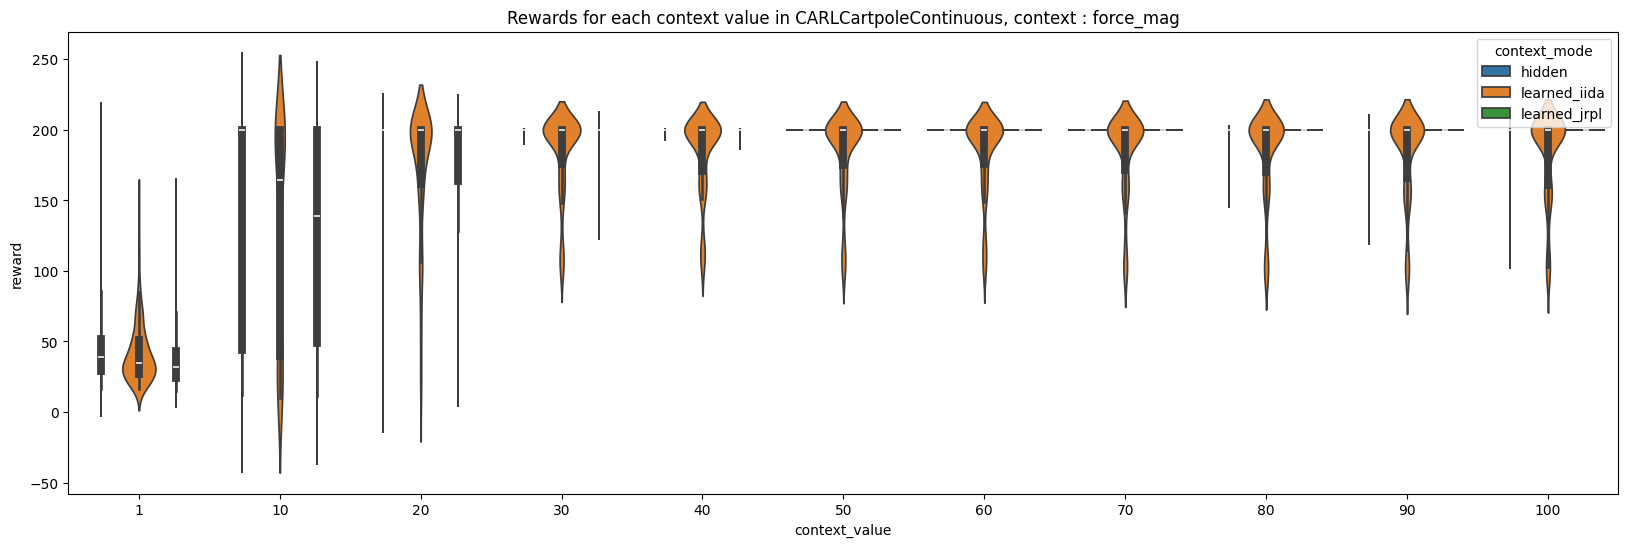

In [6]:
# Env: CARLCartpoleContinuous, context: force_mag, total_timesteps: 30000
# train_env : [25, 35, 45, 55, 65, 75]
# test_env : [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
plot_rewards("results/hydra/multirun/2024-02-09/09-12-56", 
             context_modes = ["hidden", "learned_iida", "learned_jcpl"],
          
            environment_name="CARLCartpoleContinuous, context : force_mag")

/tmp/ipykernel_3795575/272990189.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reward_df = reward_df._append({"context_mode": context_mode, "seed": seed, "context_value": context_value, "reward": reward}, ignore_index=True)


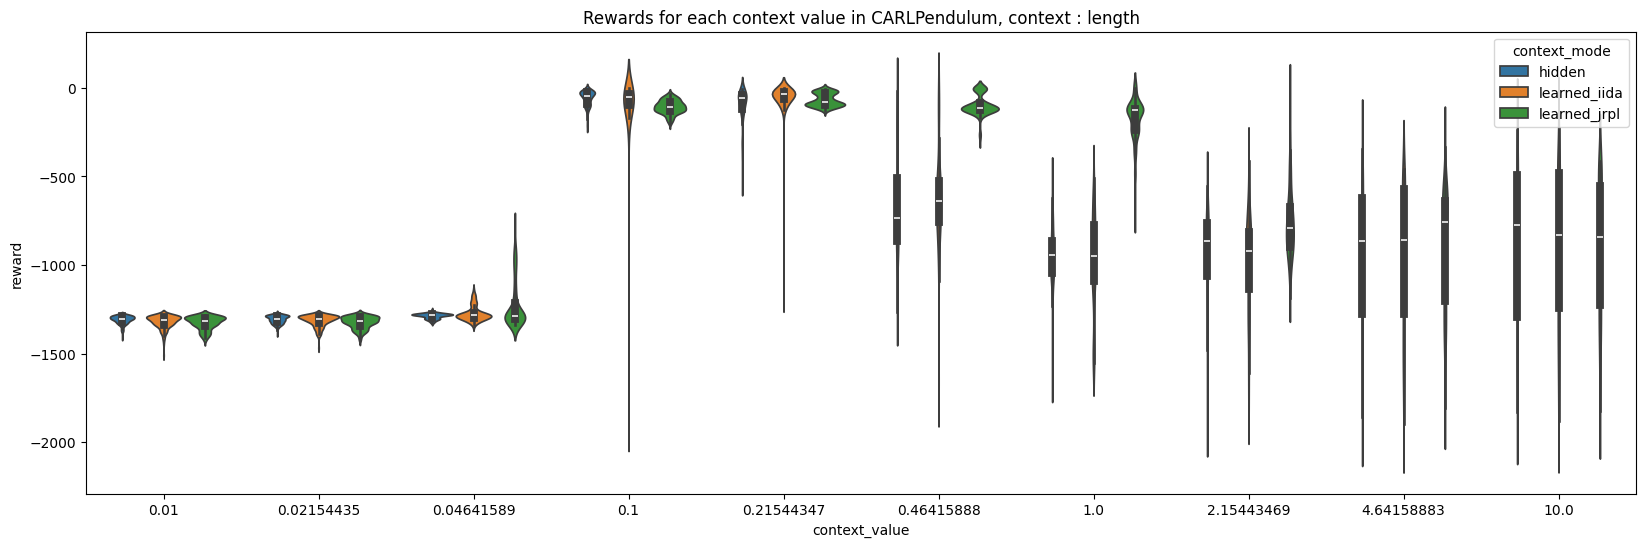

In [7]:
# Env: CARLPendulum, context: l, total_timesteps: 30000
# train_env : [0.07320794, 0.15772173, 0.33980118, 0.73207944, 1.57721735]
# test_env : [ 0.01      ,  0.02154435,  0.04641589,  0.1       ,  0.21544347,   0.46415888,  1.        ,  2.15443469,  4.64158883, 10.        ]
plot_rewards("results/hydra/multirun/2024-02-09/13-33-44", 
             context_modes = ["hidden", "learned_iida", "learned_jcpl"],
    
            environment_name="CARLPendulum, context : length")

In [8]:
# Env: CARLMountainCarContinuous, context: power, total_timesteps: 30000
# train_env : [-5, -3, -1, 1, 3, 5]
# test_env :  [-10, -8, -6, -4, -2, 0, 2, 4, 6, 8, 10]
plot_rewards("results/hydra/multirun/2024-02-09/18-52-53", 
             context_modes = ["hidden", "learned_iida", "learned_jcpl"],
             #train_values=[0.00742415, 0.01238423, 0.02065813, 0.03445984, 0.05748248],
            #eval_values=[0.002     , 0.0033362 , 0.00556512, 0.00928318, 0.01548527, 0.02583099, 0.04308869, 0.07187627, 0.11989685, 0.2       ],
            environment_name="CARLMountainCarContinuous, context : power")

/tmp/ipykernel_3795575/272990189.py:68: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reward_df = reward_df._append({"context_mode": context_mode, "seed": seed, "context_value": context_value, "reward": reward}, ignore_index=True)


In [2]:

plot_rewards("results/hydra/multirun/2024-02-07/20-31-42", 

             #train_values=[25, 35, 45, 55, 65, 75],
            #eval_values=[1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
            environment_name="Ant, context : mass_torso")


/tmp/ipykernel_27014/1098855267.py:55: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  reward_df = reward_df._append({"context_mode": context_mode, "seed": seed, "context_value": context_value, "reward": reward}, ignore_index=True)
/tmp/ipykernel_27014/1098855267.py:60: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  sns.violinplot(data=reward_df, x="context_value", y="reward", hue="context_mode", palette=context_colors, scale="width", )#inner="quartile")


/tmp/ipykernel_27014/1098855267.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  wilcoxon_df = wilcoxon_df._append({"context_value": context_value, "statistic": statistic, "p_value": p_value, "higher_mean": higher_mean, context_mode_1: rewards_1.mean(), context_mode_2: rewards_2.mean()}, ignore_index=True)


,0,1,2,3,4,5,6,7,8,9,10
context_value,1,10,20,30,40,50,60,70,80,90,100
statistic,8622.0,8461.0,7841.0,7723.0,7920.0,8091.0,7635.0,9094.0,8448.0,7086.0,6351.0
p_value,0.081438,0.05252,0.007031,0.004521,0.009351,0.016834,0.003212,0.243419,0.050617,0.000299,0.000006
higher_mean,learned_jcpl,learned_jcpl,learned_jcpl,learned_jcpl,learned_jcpl,learned_jcpl,learned_jcpl,learned_jcpl,learned_jcpl,learned_jcpl,learned_jcpl
learned_jcpl,461.756659,456.453305,455.008029,448.850097,444.141896,460.292029,476.800454,424.863562,456.35765,464.405499,484.112523
learned_iida,419.870847,416.648738,393.578974,380.856312,385.614359,405.045269,412.001976,399.70079,408.477,382.941472,386.567854


In [ ]:
def multivariable_wilcoxon_test(df: pd.DataFrame,):
    """
    Given a dataframe with columns: context_mode, seed, context_value, reward
    performs a wilcoxon test for each pair of context_mode, for each context_value
    returns a dataframe with columns: context_value, context_mode_1, context_mode_2, statistic, p_value
    """
    wilcoxon_df = pd.DataFrame(columns=["context_value, context_mode_1, context_mode_2, statistic, p_value"])
    for context_value in df["context_value"].unique():
        for context_mode_1 in df["context_mode"].unique():
            for context_mode_2 in df["context_mode"].unique():
                if context_mode_1 != context_mode_2:
                    rewards_1 = df[(df["context_mode"] == context_mode_1) & (df["context_value"] == context_value)]["reward"]
                    rewards_2 = df[(df["context_mode"] == context_mode_2) & (df["context_value"] == context_value)]["reward"]
                    try:
                        statistic, p_value = wilcoxon(rewards_1, rewards_2)
                    except ValueError:
                        statistic, p_value = 0, 1
                    wilcoxon_df = wilcoxon_df._append({"context_value": context_value, "context_mode_1": context_mode_1, "context_mode_2": context_mode_2, "statistic": statistic, "p_value": p_value}, ignore_index=True)
    return wilcoxon_df
def plot_p_values(wilcoxon_df: pd.DataFrame):
    """
    Given a dataframe with columns: context_value, context_mode_1, context_mode_2, statistic, p_value
    for each context_value:
    - creates a 2D matrix of p_values for each pair of context_mode
    - plots the 2D matrix
    """
    for context_value in wilcoxon_df["context_value"].unique():
        p_values = np.zeros((len(wilcoxon_df["context_mode_1"].unique()), len(wilcoxon_df["context_mode_2"].unique())))
        for i, context_mode_1 in enumerate(wilcoxon_df["context_mode_1"].unique()):
            for j, context_mode_2 in enumerate(wilcoxon_df["context_mode_2"].unique()):
                p_values[i, j] = wilcoxon_df[(wilcoxon_df["context_value"] == context_value) & (wilcoxon_df["context_mode_1"] == context_mode_1) & (wilcoxon_df["context_mode_2"] == context_mode_2)]["p_value"]
        plt.figure(figsize=(20, 6))
        sns.heatmap(p_values, annot=True, xticklabels=wilcoxon_df["context_mode_2"].unique(), yticklabels=wilcoxon_df["context_mode_1"].unique())
        plt.title(f"p_values for each pair of context_mode for context_value {context_value}")
        plt.show()
                  